In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_auc_score, f1_score, recall_score, precision_score

from imblearn.over_sampling import SMOTE
from collections import Counter


## Overview
We are in the call centre department and have a dataset about which customer subscribe our term deposit with their backgrounds and how we contact them. We want to investigate how to increase the rate of term deposit subscription using the data provided and also train a machine learning model to predict which customer is likely to subscribe the term deposit, so that we can focus the manpower to call them without blindly cold calling customers

## Summary
### 1. Customer backgrounds and behaviors
Most of the term deposit subscribers are in between 30 to 40 years old with a stable full time job and have high education level. They pay back credit interest punctually and do not have personal loans

### 2. What we can do as call agent?
To increase the success rate to attract customer, we have trained the machine learning model found out these are the key factors for a higher subscription rate of the term deposit:
1. Calling customer in summer season
2. Contact customer's cellphone instead of landline
3. Contact customer who have record of subscribing our other products through our previous marketing campaign
4. Contact customer who have good record of credit payment

Follow up calls can also increase the subscribing rate with the following recommended measures:
- 90% of customers will subscribe us within 3 calls. Make sure you don't call too many times and put too much effort in one customer
- Calling interval should be around 3 to 6 days without annoying customers too much and they have time to think about it

## Data exploration

### We got 41k datapoint and 11% of contacted customers subscribed the term deposit

In [2]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
print('Percentage of subscribing term deposit: ' + str(round(100 * df[df['y'] == 'yes']['y'].count() / df.shape[0], ndigits=2)))

Percentage of subscribing term deposit: 11.27


### The data is clean as no missing value is found for each column and datapoint

In [5]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

## Demographic of term deposit subsribers

### Most of the subscribers are between 30 to 40 years old and distribution are similar to the non-subscribers

Text(0.5, 1.0, 'Age distribution of term deposit subscribers')

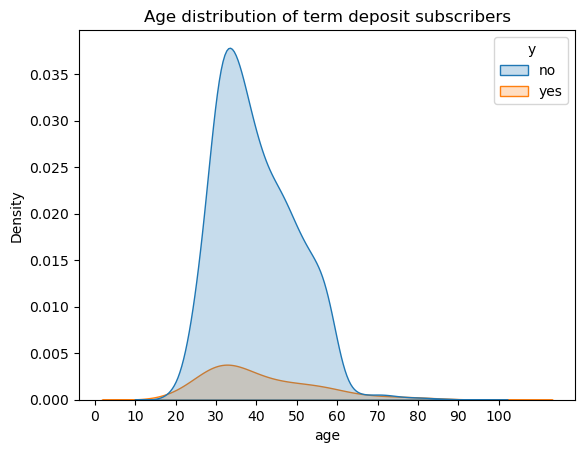

In [6]:
sns.kdeplot(data=df, x='age', hue='y', fill=True, bw_adjust=2)
plt.xticks(range(0, 101, 10))
plt.title('Age distribution of term deposit subscribers')

In [7]:
df['job'].value_counts()

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

### Majority of subsribers are having 9-5 jobs and white-collar have the largest number of subscribers

Text(0.5, 1.0, 'Job title of term deposit subscribers')

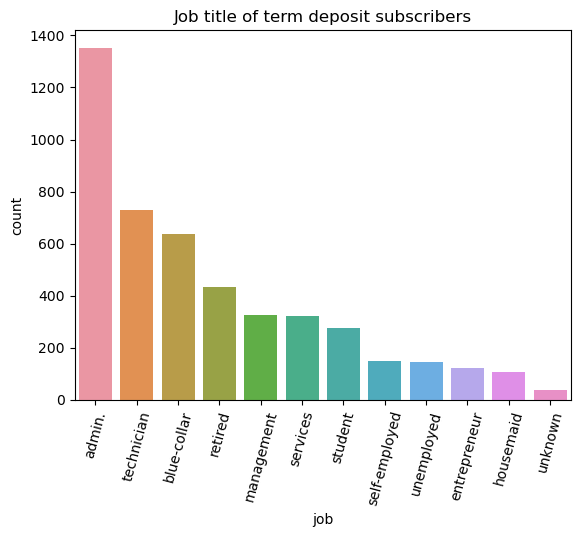

In [8]:
sns.countplot(data=df[df['y'] == 'yes'], x='job', order=df[df['y'] == 'yes']['job'].value_counts().index)
plt.xticks(rotation=75)
plt.title('Job title of term deposit subscribers')

### Married customers are more interested in our term deposit product

Text(0.5, 1.0, 'Marital status of term deposit subscribers')

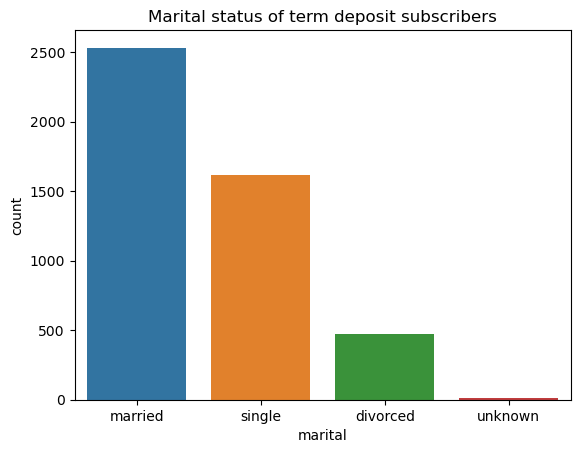

In [9]:
sns.countplot(data=df[df['y'] == 'yes'], x='marital', order=df[df['y'] == 'yes']['marital'].value_counts().index)
plt.title('Marital status of term deposit subscribers')

### Degree holder are more likely to subscribe our term deposit

Text(0.5, 1.0, 'Education level of our term deposit subscribers')

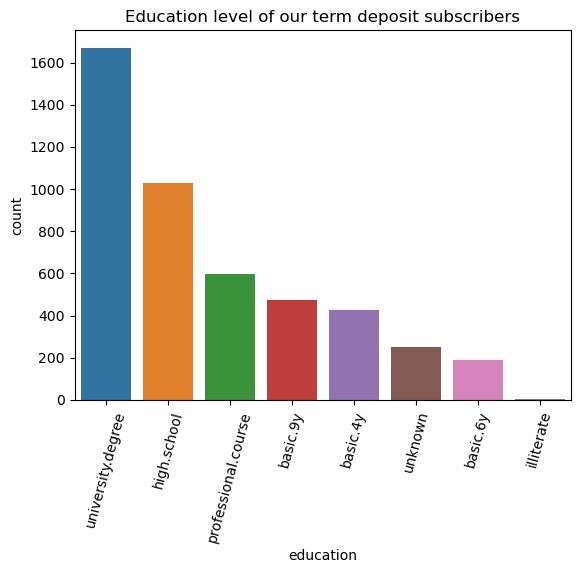

In [10]:
sns.countplot(data=df[df['y'] == 'yes'], x='education', order=df[df['y'] == 'yes']['education'].value_counts().index)
plt.xticks(rotation=75)
plt.title('Education level of our term deposit subscribers')

In [11]:
df['default'].value_counts()

default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

## Financial behaviour of term deposit subscribers

### Huge amount of subsribers are paying their monthly interest punctually

Text(0.5, 1.0, 'Any unpaid credit interest payment of term deposit subscribers')

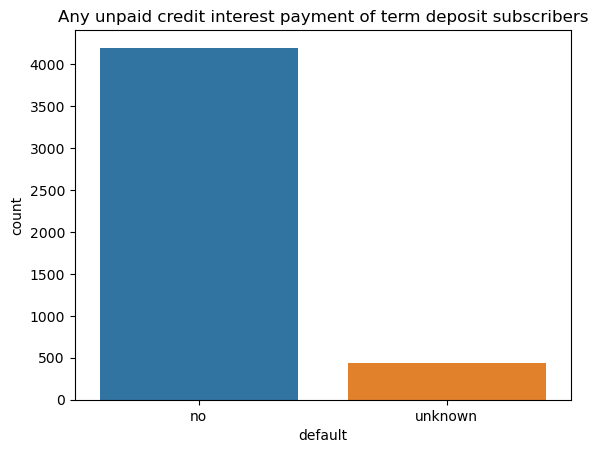

In [12]:
sns.countplot(data=df[df['y'] == 'yes'], x='default', order=df[df['y'] == 'yes']['default'].value_counts().index)
plt.title('Any unpaid credit interest payment of term deposit subscribers')

### Having housing loan is not a factor of subscribing the term deposit 

Text(0.5, 1.0, 'Housing loan of term deposit subscribers')

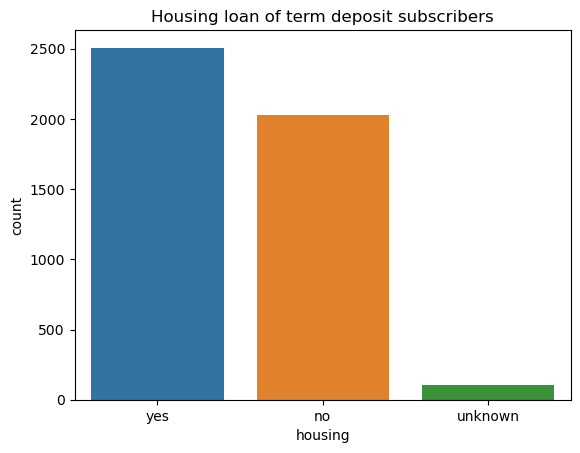

In [13]:
sns.countplot(data=df[df['y'] == 'yes'], x='housing', order=df[df['y'] == 'yes']['housing'].value_counts().index)
plt.title('Housing loan of term deposit subscribers')

### Large portion of subscribers do not have personal loans

Text(0.5, 1.0, 'Personal loan of term deposit subscribers')

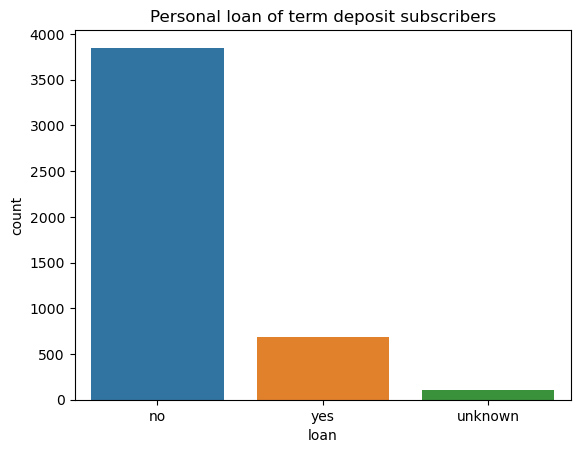

In [14]:
sns.countplot(data=df[df['y'] == 'yes'], x='loan', order=df[df['y'] == 'yes']['loan'].value_counts().index)
plt.title('Personal loan of term deposit subscribers')

## Marketing factors for successfully subscribe our term deposit

### Most of our subscribers are contact and apply through their cell phone

Text(0.5, 1.0, 'Contact type in applying for term deposit')

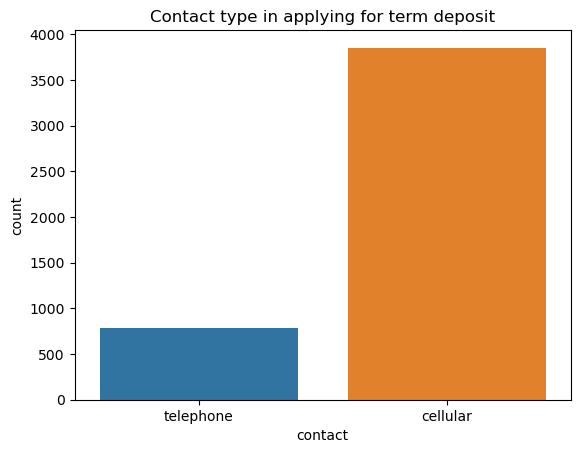

In [15]:
sns.countplot(data=df[df['y'] == 'yes'], x='contact')
plt.title('Contact type in applying for term deposit')

In [16]:
df[df['y'] == 'yes']['month'].value_counts()

month
may    886
aug    655
jul    649
jun    559
apr    539
nov    416
oct    315
mar    276
sep    256
dec     89
Name: count, dtype: int64

### Summer season have a significant successful case compare to other months

Text(0.5, 1.0, 'Successful term deposit subscription by month')

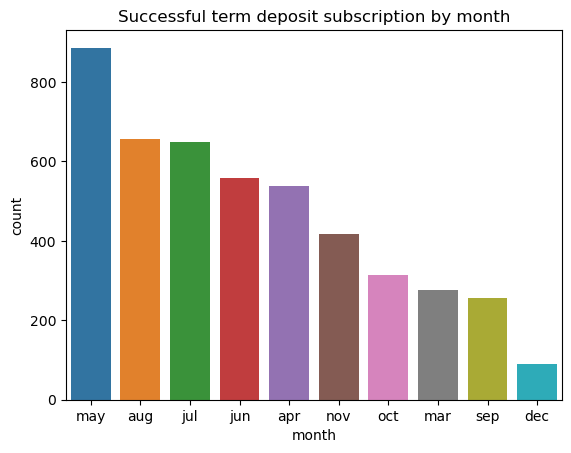

In [17]:
sns.countplot(data=df[df['y'] == 'yes'], x='month', order=df[df['y'] == 'yes']['month'].value_counts().index)
plt.title('Successful term deposit subscription by month')

### Day of week is not a important factor in customer's decision of subscriping the term deposit 

Text(0.5, 1.0, 'Successful term deposit subscription by day of week')

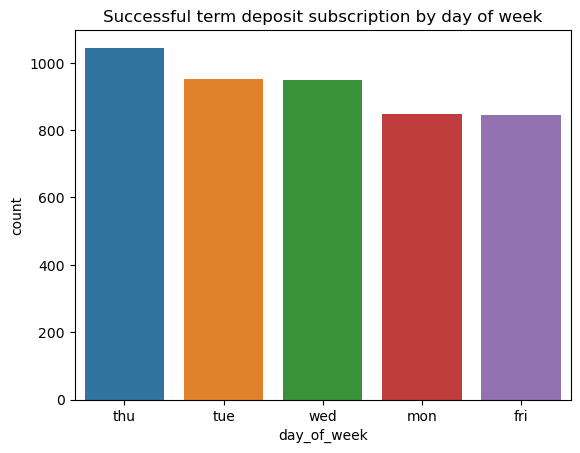

In [18]:
sns.countplot(data=df[df['y'] == 'yes'], x='day_of_week', order=df[df['y'] == 'yes']['day_of_week'].value_counts().index)
plt.title('Successful term deposit subscription by day of week')

### It seems obvious but customer who subscribe the term deposit have significant phone call duration with about 2.5 min or above

Text(0.5, 1.0, 'Call duration between rejected and accepted subscription of term deposit')

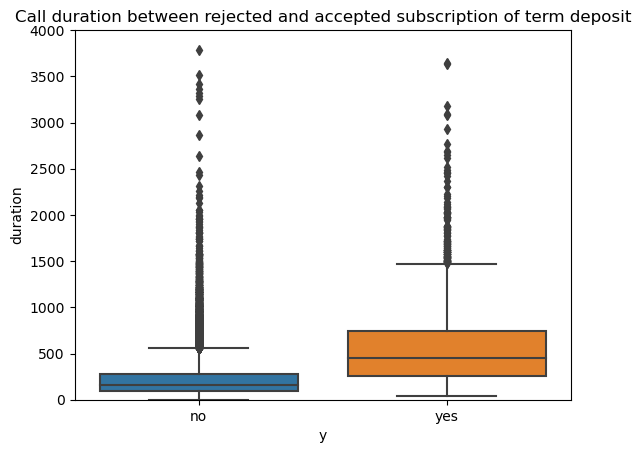

In [19]:
sns.boxplot(data=df, x='y', y='duration')
plt.ylim(0, 4000)
plt.title('Call duration between rejected and accepted subscription of term deposit')

In [20]:
df_sub = df[df['y'] == 'yes']['duration'].describe().to_frame().rename(columns={'duration': 'subscribed'})
df_nonsub = df[df['y'] == 'no']['duration'].describe().to_frame().rename(columns={'duration': 'non-subscribed'})

df_duration = pd.concat([df_sub, df_nonsub], axis=1)
df_duration

,subscribed,non-subscribed
count,4640.000000,36548.000000
mean,553.191164,220.844807
std,401.171871,207.096293
min,37.000000,0.000000
25%,253.000000,95.000000
50%,449.000000,163.500000
75%,741.250000,279.000000
max,4199.000000,4918.000000


### Near 90% of the subscribers accept our terms deposit under 3 phone calls, and the majority subscribed us in only 1 call

Text(0.5, 1.0, 'Successful subscription by number of phone calls contacted')

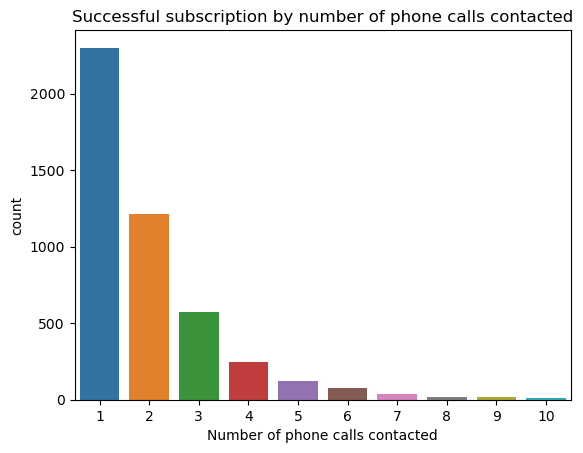

In [21]:
sns.countplot(data=df[df['y'] == 'yes'], x='campaign', order=df[df['y'] == 'yes']['campaign'].value_counts().index[:10])
plt.xlabel('Number of phone calls contacted')
plt.title('Successful subscription by number of phone calls contacted')

Text(0.5, 1.0, 'Cumulative Percentage of Campaign Count')

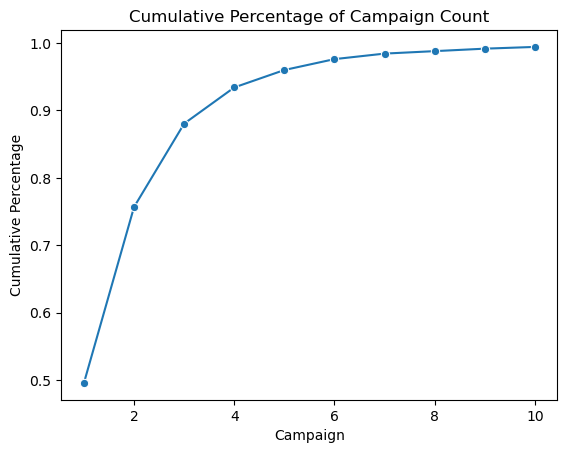

In [22]:
campaign_counts = df[df['y'] == 'yes']['campaign'].value_counts().sort_index()
cumulative_percentage = campaign_counts.cumsum() / campaign_counts.sum()

sns.lineplot(data=cumulative_percentage[:10], marker='o')
plt.xlabel('Campaign')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Percentage of Campaign Count')


### Apart from the customers who have not contact for a long time, Contacting customers within 3 to 6 days after the previous contact have a higher chance to subscribe us

Text(0.5, 1.0, 'Days passed after last contact from previous campaign and subscribed to term deposit')

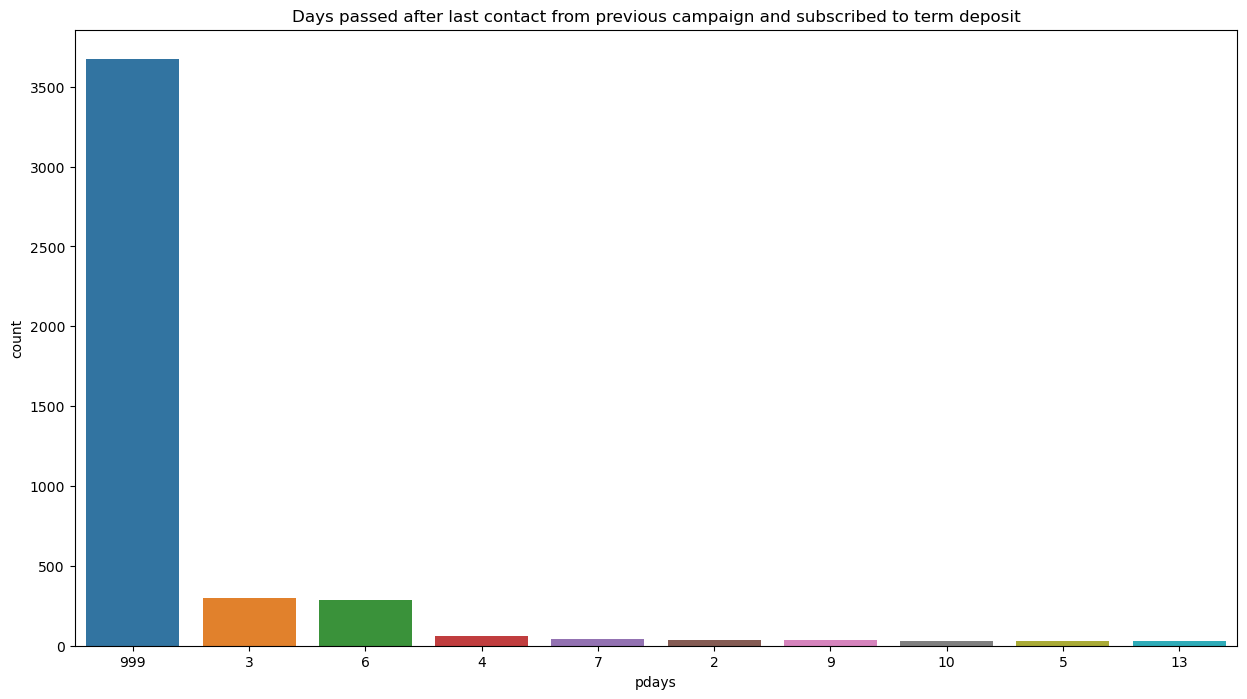

In [23]:
plt.figure(figsize=(15,8))
sns.countplot(data=df[df['y'] == 'yes'], x='pdays', order=df[df['y'] == 'yes']['pdays'].value_counts().index[:10])
plt.title('Days passed after last contact from previous campaign and subscribed to term deposit')

In [24]:
df_poutcome = df.groupby('y')['poutcome'].agg({'value_counts'}).reset_index()

df_poutcome_sum = df_poutcome.groupby('y')['value_counts'].sum().reset_index().rename(columns={'value_counts':'y_total'})

df_poutcome_groupby = df_poutcome.merge(df_poutcome_sum, on='y', how='left')
df_poutcome_groupby['percentage'] = df_poutcome_groupby['value_counts'] / df_poutcome_groupby['y_total']

del df_poutcome, df_poutcome_sum

### Customers who have joined other plans previously, are usually have a higher chance to subscribe our term deposit plan

Text(0.5, 1.0, 'Customer joined at least 1 campaign before may lead to current success of term deposit subscription')

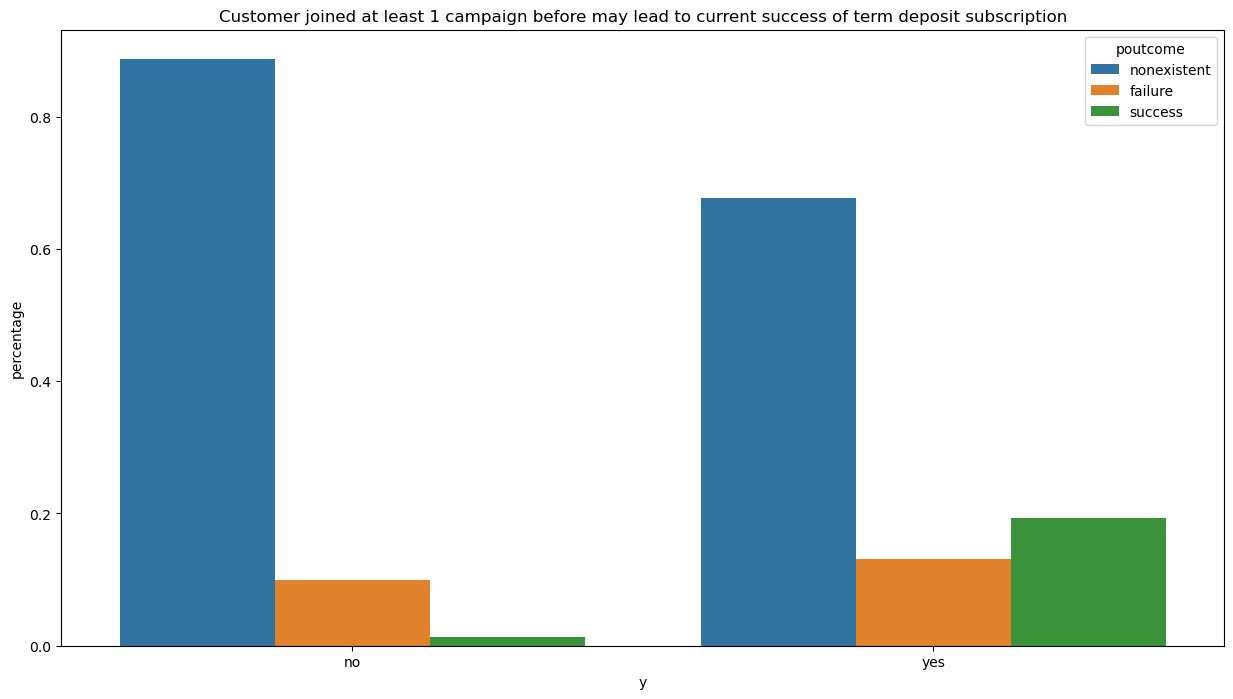

In [25]:
plt.figure(figsize=(15,8))
sns.barplot(data=df_poutcome_groupby, x='y', y='percentage', hue='poutcome')
plt.title('Customer joined at least 1 campaign before may lead to current success of term deposit subscription')

### Lower consumer price index have a slightly impact of subscribing our term deposit because they have more free cash in their hand

Text(0.5, 1.0, 'Consumer price index at the moment for reject or accept term deposit subscription')

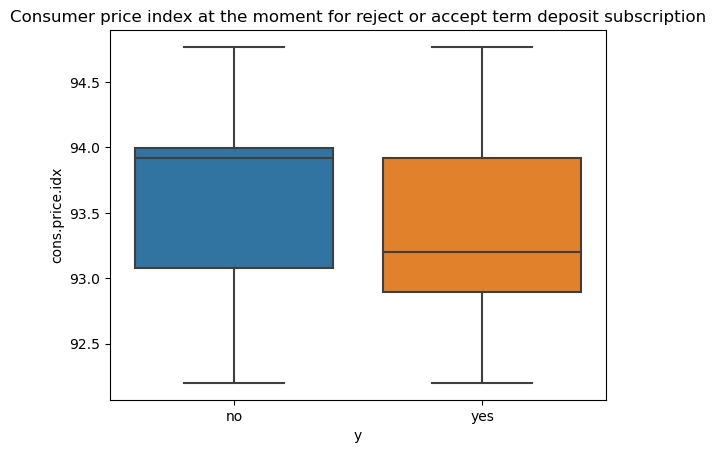

In [26]:
sns.boxplot(data=df, x='y', y='cons.price.idx')
plt.title('Consumer price index at the moment for reject or accept term deposit subscription')

## Cleaning the data and train machine learning model to predict which customer will subscribe our term deposit

### Data cleaning

In [27]:
df_test = df.copy()

In [28]:
# Create function for zscore multiple columns
def apply_zscore(df, col):
    for item in col:
        df[item] = zscore(df[item])

In [29]:
# Apply zscore to specific columns
zscore_columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 'cons.price.idx', 'euribor3m']
apply_zscore(df_test, zscore_columns)

In [30]:
# Drop the unnecessary columns
drop_columns = ['emp.var.rate','cons.conf.idx','nr.employed']
df_test.drop(drop_columns, axis=1, inplace=True)


In [31]:
# Map the subscribing result to 1 or 0
df_test['y'] = df_test['y'].map({'yes': 1, 'no': 0})

In [32]:
# Convert categorical variables to dummy variables
dummy_columns = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
df_1 = pd.get_dummies(df_test, columns=dummy_columns)

In [33]:
# Drop the columns with too many outliers
df_1.drop(['pdays'], axis=1, inplace=True)

### Split the data and train the model

In [34]:
# initalize the xgboost model
xgb_model = XGBClassifier()

In [35]:
# Set up parameters for grid search
parameters = {
    'max_depth':[3, 4, 5],
    'learning_rate':[0.1, 0.2, 0.3],
    'n_estimators':[100, 200, 300]
}

X_train, X_test, y_train, y_test = train_test_split(df_1.drop('y', axis=1), df_1['y'], test_size=0.2)

clf = GridSearchCV(xgb_model, parameters, cv=5, scoring='f1')

In [36]:
# Train the model
clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [37]:
# Predict using test dataset
y_predict = clf.predict(X_test)

### We focus on the recall rate as missing the customer who truely want to subscribe, is more serious than contacting the customer who don't want to subscribe

In [38]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7332
           1       0.64      0.53      0.58       906

    accuracy                           0.91      8238
   macro avg       0.79      0.75      0.77      8238
weighted avg       0.91      0.91      0.91      8238



In [39]:
print("f1 score:",f1_score(y_test, y_predict))
print("recall score:",recall_score(y_test, y_predict))
print("roc score:",roc_auc_score(y_test, y_predict))

f1 score: 0.5779650812763396
recall score: 0.5298013245033113
roc score: 0.746147252540799


### The model have a lot of false negative case (buttom left) which will make us missing customer subscription opportunity

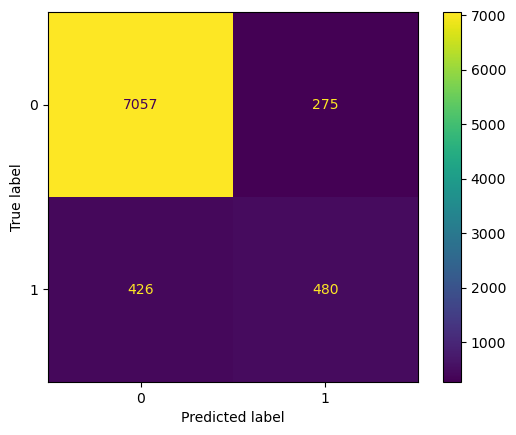

In [40]:
cm = confusion_matrix(y_test, y_predict, labels=clf.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
cm_display.plot()

### Apart from the call duration we can't control, the call month is the key factor for the model to predict the customer subscription

<Axes: xlabel='feature_importance', ylabel='column'>

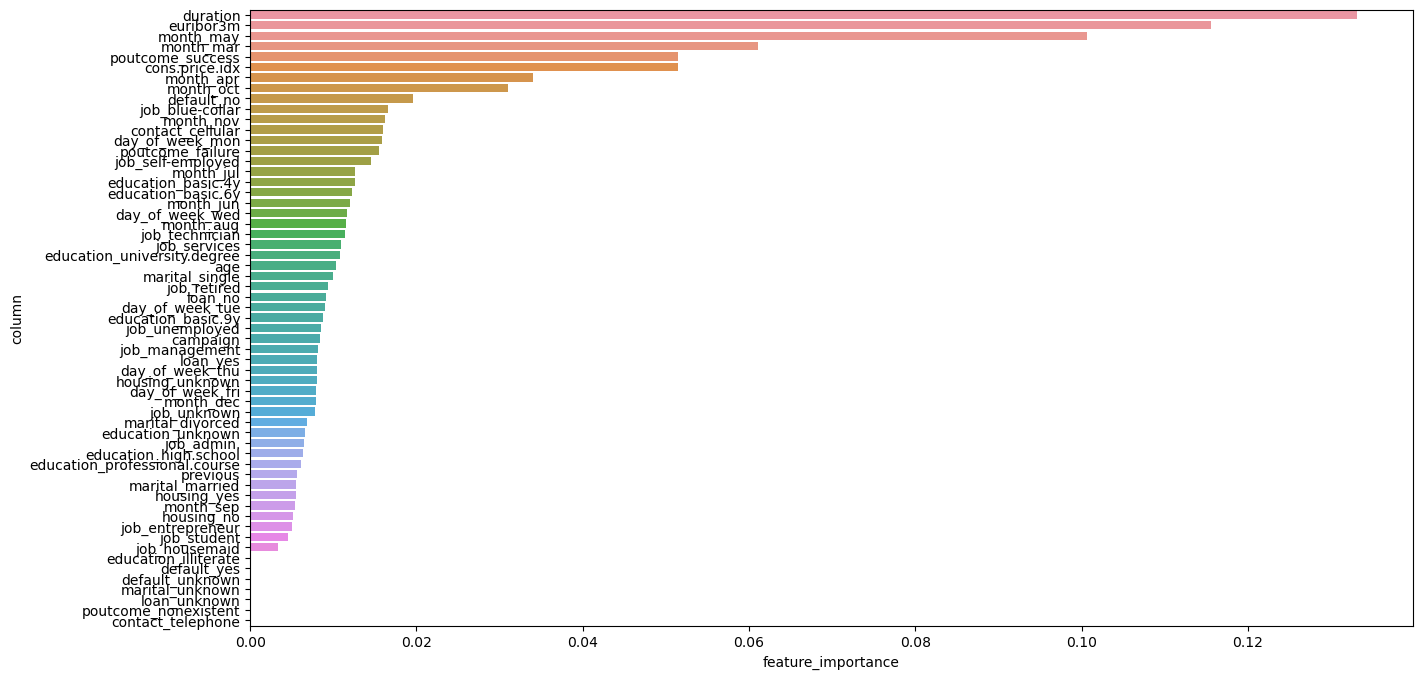

In [41]:
best_model = clf.best_estimator_
best_features = best_model.feature_importances_
column_names = list(X_train.columns)
feature_importance = list(best_features)

df_feature_importance = pd.DataFrame({'column': column_names, 'feature_importance': feature_importance})

plt.figure(figsize=(15,8))
sns.barplot(x='feature_importance', y='column', data=df_feature_importance.sort_values(by='feature_importance', ascending=False))

### As the sample of success subscription is quite low, let us oversample the success datapoint using SMOTE method and train as another model

#### The ratio of rejecting subscription to accepting subscription data will be 1:1 after oversampling

In [42]:
counter = Counter(y_train)
print("Data size before SMOTE:", counter)

SMOTE = SMOTE()
X_train_sm, y_train_sm = SMOTE.fit_resample(X_train, y_train)
counter = Counter(y_train_sm)

print("Data size after SMOTE:", counter)

Data size before SMOTE: Counter({0: 29216, 1: 3734})


c:\Users\david\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\david\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


Data size after SMOTE: Counter({0: 29216, 1: 29216})


In [43]:
# Initialize another xgboost model using oversample data
clf_sm = GridSearchCV(xgb_model, parameters, cv=5, scoring='f1')

In [44]:
# Train the model using oversample data
clf_sm.fit(X_train_sm, y_train_sm)

In [ ]:
# Predict the result using newly trained model
y_sm_predict = clf_sm.predict(X_test)

In [ ]:
# Overview of the result
print(classification_report(y_test, y_sm_predict))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      7306
           1       0.53      0.74      0.62       932

    accuracy                           0.90      8238
   macro avg       0.75      0.83      0.78      8238
weighted avg       0.92      0.90      0.90      8238



### Recall score is significant increased about 40% using the oversample data by SMOTE method, meaning more true potential subscribers are identified

In [ ]:
print("Model result using original data to train:")
print("f1 score:",f1_score(y_test, y_predict))
print("recall score:",recall_score(y_test, y_predict))
print("roc score:",roc_auc_score(y_test, y_predict))

print("\n")
print("Model result using oversample data to train:")
print("f1 score:",f1_score(y_test, y_sm_predict))
print("recall score:",recall_score(y_test, y_sm_predict))
print("roc score:",roc_auc_score(y_test, y_sm_predict))

Model result using original data to train:
f1 score: 0.5757211538461539
recall score: 0.5139484978540773
roc score: 0.7396597129292286


Model result using oversample data to train:
f1 score: 0.6177916852928028
recall score: 0.7414163090128756
roc score: 0.8286878971836893


### The false negative results (bottom left) shifted to the right column which is want we what to achieve

#### More true potential subscribers are predicted, with the increase in predicting potential subscribers who turns out rejecting the subscription. However, the business impact of calling more customers is lower than missing the true potential subscribers 

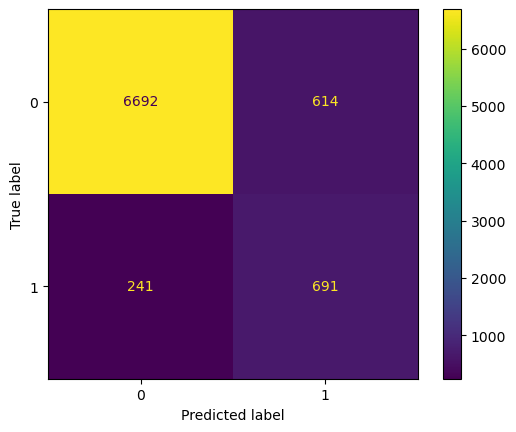

In [ ]:
cm = confusion_matrix(y_test, y_sm_predict, labels=clf_sm.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_sm.classes_)
cm_display.plot()

### After tunning the model, The top 10 key factor of customer subscription predicted by model are generally:
- Months calling to customer
- Contact customer's cellphone number
- Customers subscribed other product from our previous marketing campaign
- Good record of credit payment without late

<Axes: xlabel='feature_importance', ylabel='column'>

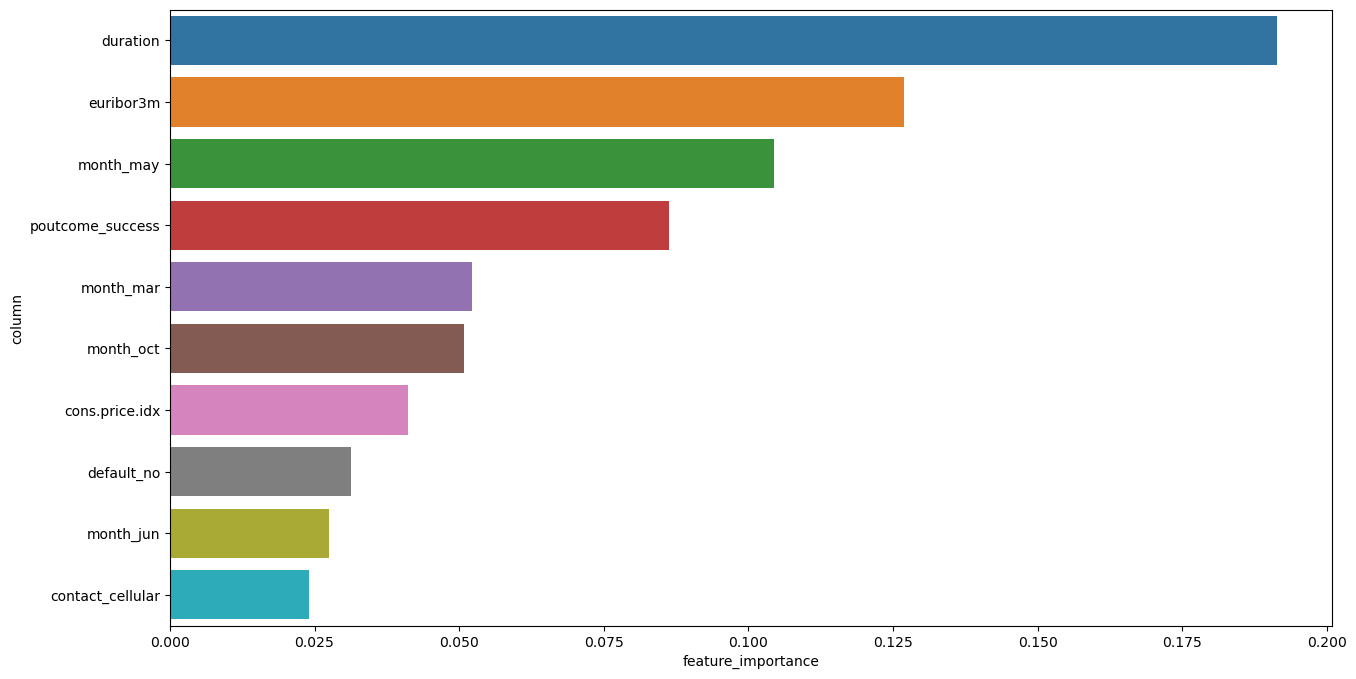

In [ ]:
best_model_sm = clf_sm.best_estimator_
best_features_sm = best_model_sm.feature_importances_
column_names_sm = list(X_train_sm.columns)
feature_importance_sm = list(best_features_sm)

df_feature_importance_sm = pd.DataFrame({'column': column_names, 'feature_importance': feature_importance})

plt.figure(figsize=(15,8))
sns.barplot(x='feature_importance', y='column', data=df_feature_importance_sm.sort_values(by='feature_importance', ascending=False)[:10])